# Train a CNN on GTZAN MFCC segments

This notebook loads precomputed MFCC segments, normalizes them, trains a CNN, and evaluates performance.


In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical

DATA_DIR = Path('..') / 'data' / 'processed'
MODEL_DIR = Path('..') / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Load features and labels
X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')
classes = np.load(DATA_DIR / 'classes.npy', allow_pickle=True)

print('Train:', X_train.shape, y_train.shape)
print('Val:', X_val.shape, y_val.shape)
print('Test:', X_test.shape, y_test.shape)
print('Classes:', classes)


Train: (7021, 20, 215) (7021,)
Val: (1759, 20, 215) (1759,)
Test: (2200, 20, 215) (2200,)
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [3]:
# Normalize using training set statistics and add channel dimension
mean = X_train.mean()
std = X_train.std() + 1e-8

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

np.save(MODEL_DIR / 'mfcc_mean.npy', np.array([mean], dtype=np.float32))
np.save(MODEL_DIR / 'mfcc_std.npy', np.array([std], dtype=np.float32))

num_classes = len(classes)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print('X_train:', X_train.shape, 'y_train:', y_train_cat.shape)


X_train: (7021, 20, 215, 1) y_train: (7021, 10)


In [4]:
# Build CNN model
input_shape = X_train.shape[1:]
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 215, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 54, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 54, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 54, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,421,194 (5.42 MB)

 Trainable params: 1,421,194 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=32,
    verbose=1,
)


Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.3864 - loss: 1.6649 - val_accuracy: 0.4036 - val_loss: 1.4979
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5411 - loss: 1.2521 - val_accuracy: 0.5514 - val_loss: 1.1486
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6327 - loss: 1.0222 - val_accuracy: 0.6146 - val_loss: 1.0416
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6868 - loss: 0.8738 - val_accuracy: 0.6265 - val_loss: 1.0121
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7372 - loss: 0.7392 - val_accuracy: 0.6958 - val_loss: 1.0198
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7774 - loss: 0.6219 - val_accuracy: 0.6663 - val_loss: 1.0638
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8044 - loss: 0.5439 - val_accuracy: 0.7021 - val_loss: 0.9468
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8335 - loss: 0.4645 - 

Test accuracy: 0.7055
              precision    recall  f1-score   support

       blues       0.72      0.76      0.74       220
   classical       0.83      0.94      0.88       220
     country       0.73      0.66      0.70       220
       disco       0.77      0.49      0.60       220
      hiphop       0.62      0.69      0.65       220
        jazz       0.85      0.83      0.84       220
       metal       0.86      0.68      0.76       220
         pop       0.70      0.72      0.71       220
      reggae       0.52      0.72      0.61       220
        rock       0.57      0.56      0.57       220

    accuracy                           0.71      2200
   macro avg       0.72      0.71      0.70      2200
weighted avg       0.72      0.71      0.70      2200



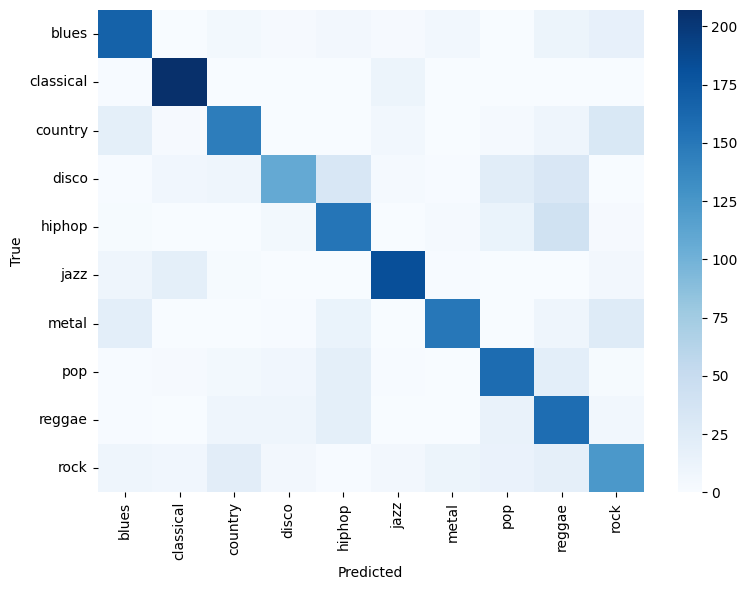

In [6]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test accuracy:', round(float(test_acc), 4))

y_pred = model.predict(X_test, verbose=0)
y_pred_labels = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_labels, target_names=classes))
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [7]:
# Save model
model_path = MODEL_DIR / 'gtzan_cnn.h5'
model.save(model_path)
print('Saved model to', model_path)


Saved model to ..\models\gtzan_cnn.h5
